In [58]:
 # Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

# Keras deep learning imports
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Dropout, Input, add 
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras import optimizers

# Data splitting
from sklearn.model_selection import train_test_split

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [59]:
x = np.load('./dataset/sign-language/X.npy')
y = np.load('./dataset/sign-language/Y.npy')

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')

X shape: (2062, 64, 64)
Y shape: (2062, 10)


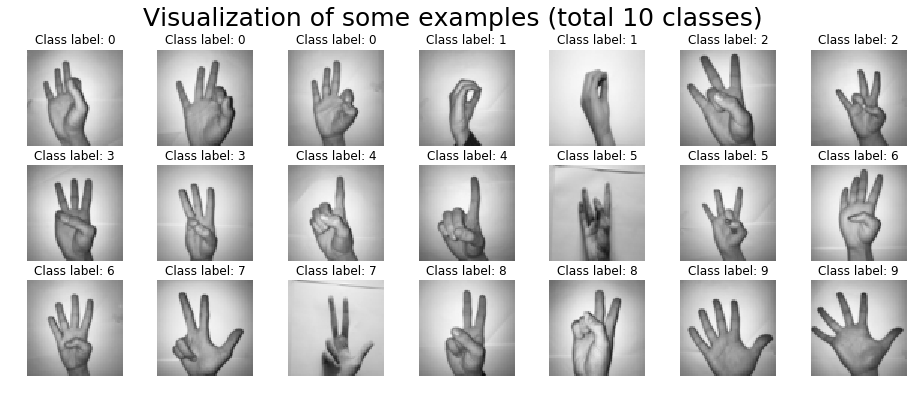

In [60]:
plt.figure(figsize=(16, 6))
figIdx = 1
for i in range(len(x)):
    if i%100==0 and figIdx <= 3*7:
        plt.subplot(3,7,figIdx)
        plt.title(f'Class label: {y[i].argmax()}')
        plt.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        figIdx+=1
plt.suptitle(f'Visualization of some examples (total {y.shape[1]} classes)', fontsize=25)
plt.show()

In [61]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state = 42)
xTrain = xTrain.reshape(-1, 64, 64, 1)
xTest = xTest.reshape(-1, 64, 64, 1)

In [81]:

class ResNet:
    def resnet_blocks(x, F, stride, red=False,reg=0.0001, bnEps=2e-5, bnMom=0.9):

        shortcut = x
  
        x = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = Conv2D(int(0.25*F), kernel_size = (1, 1), kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)
        
        
        x = Conv2D(int(0.25*F), kernel_size=(3, 3), strides=stride, padding="same", kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=-1, epsilon=bnEps,momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = Conv2D(F, (1, 1), kernel_regularizer=l2(reg))(x)
        
        if red:
            shortcut = Conv2D(F, kernel_size=(1, 1), strides=stride, kernel_regularizer=l2(reg))(shortcut)

        x = add([x, shortcut])

        return x
    
    
    def create_resnet(numClasses, inputShape, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):
        
        inputs = Input(shape=inputShape)
        
        x = BatchNormalization(axis=-1, epsilon=bnEps,momentum=bnMom)(inputs)

        x = Conv2D(filters[0], (5, 5),padding="same", kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = Dropout(0.2)(x)
        
        for i in range(0, len(stages)):
            stride = (1, 1) if i == 0 else (2, 2)
            
            # ResNet Identity Block
            x = ResNet.resnet_blocks(x, filters[i + 1], stride, red=True, bnEps=bnEps, bnMom=bnMom)
            
            # ResNet Convolutional block
            for j in range(0, stages[i] - 1):
                x = ResNet.resnet_blocks(x, filters[i + 1], (1, 1), bnEps=bnEps, bnMom=bnMom)
                
        x = BatchNormalization(axis=-1, epsilon=bnEps,momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D((8, 8))(x)
        x = Dropout(0.2)(x)
        
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        out = Dense(numClasses, activation = "softmax")(x)
  
        model = Model(inputs = inputs, outputs = out)

        return model

In [82]:
inputShape = (64, 64, 1)

model = ResNet.create_resnet(10, inputShape, 
                             stages=(2, 3, 4), 
                             filters=(16, 32, 64, 64), 
                             reg=0.001, bnEps=2e-4, bnMom=0.98)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_363 (BatchN (None, 64, 64, 1)    4           input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_429 (Conv2D)             (None, 64, 64, 16)   416         batch_normalization_363[0][0]    
__________________________________________________________________________________________________
batch_normalization_364 (BatchN (None, 64, 64, 16)   64          conv2d_429[0][0]                 
__________________________________________________________________________________________________
activation

In [83]:
optimizer = optimizers.Adam(lr=0.0005)
loss = 'categorical_crossentropy'
    
model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                min_delta = 0.0,
                                                patience = 10, 
                                                verbose = 1, 
                                                mode = 'auto',
                                                baseline = None, 
                                                restore_best_weights = True)

epochs = 300
history = model.fit(xTrain, yTrain, 
                    epochs=epochs, validation_data=(xTest, yTest), 
                    callbacks=[early_stopping])


Train on 1649 samples, validate on 413 samples
Epoch 1/300
1649/1649 [==============================] - 39s 24ms/step - loss: 3.2290 - acc: 0.1001 - val_loss: 2.3448 - val_acc: 0.1308
Epoch 2/300
1649/1649 [==============================] - 18s 11ms/step - loss: 2.7642 - acc: 0.0958 - val_loss: 2.3482 - val_acc: 0.1356
Epoch 3/300
1649/1649 [==============================] - 18s 11ms/step - loss: 2.5630 - acc: 0.1043 - val_loss: 2.3576 - val_acc: 0.1114
Epoch 4/300
1649/1649 [==============================] - 18s 11ms/step - loss: 2.4521 - acc: 0.1128 - val_loss: 2.3280 - val_acc: 0.1477
Epoch 5/300
1649/1649 [==============================] - 18s 11ms/step - loss: 2.3650 - acc: 0.1528 - val_loss: 2.2927 - val_acc: 0.1646
Epoch 6/300
1649/1649 [==============================] - 18s 11ms/step - loss: 2.3104 - acc: 0.1565 - val_loss: 2.2552 - val_acc: 0.1985
Epoch 7/300
1649/1649 [==============================] - 18s 11ms/step - loss: 2.2583 - acc: 0.1819 - val_loss: 2.2022 - val_acc: 0

1649/1649 [==============================] - 19s 11ms/step - loss: 0.3972 - acc: 0.8860 - val_loss: 0.2100 - val_acc: 0.9443
Epoch 61/300
1649/1649 [==============================] - 19s 11ms/step - loss: 0.3506 - acc: 0.8993 - val_loss: 0.2141 - val_acc: 0.9613
Epoch 62/300
1649/1649 [==============================] - 19s 12ms/step - loss: 0.3504 - acc: 0.9030 - val_loss: 0.1871 - val_acc: 0.9685
Epoch 63/300
1649/1649 [==============================] - 18s 11ms/step - loss: 0.3618 - acc: 0.8908 - val_loss: 0.1732 - val_acc: 0.9564
Epoch 64/300
1649/1649 [==============================] - 17s 10ms/step - loss: 0.3152 - acc: 0.9096 - val_loss: 0.1919 - val_acc: 0.9540
Epoch 65/300
1649/1649 [==============================] - 16s 10ms/step - loss: 0.3098 - acc: 0.9218 - val_loss: 0.2025 - val_acc: 0.9540
Epoch 66/300
1649/1649 [==============================] - 17s 10ms/step - loss: 0.3379 - acc: 0.9139 - val_loss: 0.1275 - val_acc: 0.9782
Epoch 67/300
1649/1649 [=======================

1649/1649 [==============================] - 18s 11ms/step - loss: 0.1693 - acc: 0.9648 - val_loss: 0.1274 - val_acc: 0.9831
Epoch 120/300
1649/1649 [==============================] - 19s 11ms/step - loss: 0.1396 - acc: 0.9776 - val_loss: 0.1254 - val_acc: 0.9855
Epoch 121/300
1649/1649 [==============================] - 18s 11ms/step - loss: 0.1620 - acc: 0.9703 - val_loss: 0.0821 - val_acc: 0.9903
Epoch 122/300
1649/1649 [==============================] - 19s 12ms/step - loss: 0.1486 - acc: 0.9745 - val_loss: 0.1020 - val_acc: 0.9903
Restoring model weights from the end of the best epoch
Epoch 00122: early stopping


In [84]:
model.save_weights('./weights/asl-digits-resnet_1.h5')

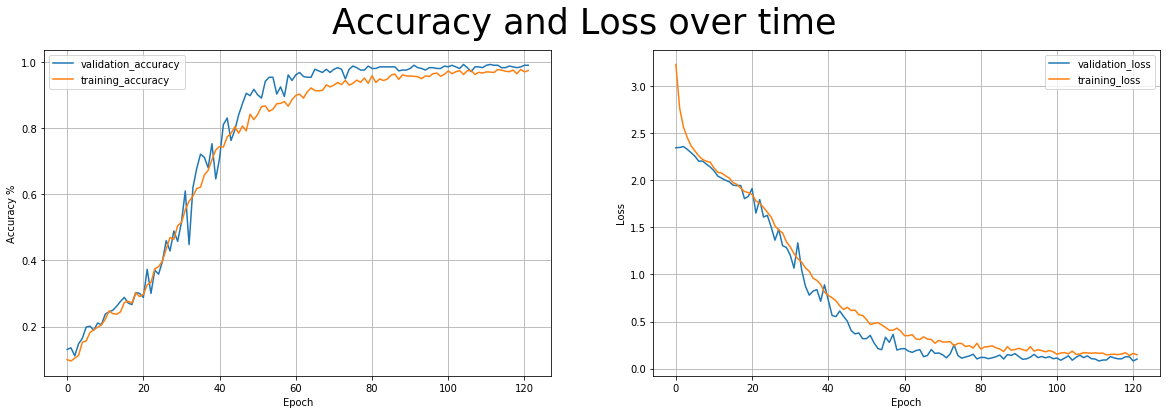

In [85]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(history.history["val_acc"],label="validation_accuracy")
plt.plot(history.history["acc"],label="training_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss")
plt.plot(history.history["loss"],label="training_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle("Accuracy and Loss over time",fontsize=35)

plt.show()

In [86]:
pred = model.predict(xTest)
predLabels = np.argmax(pred, axis = 1)
yLabels = np.argmax(yTest, axis=1)


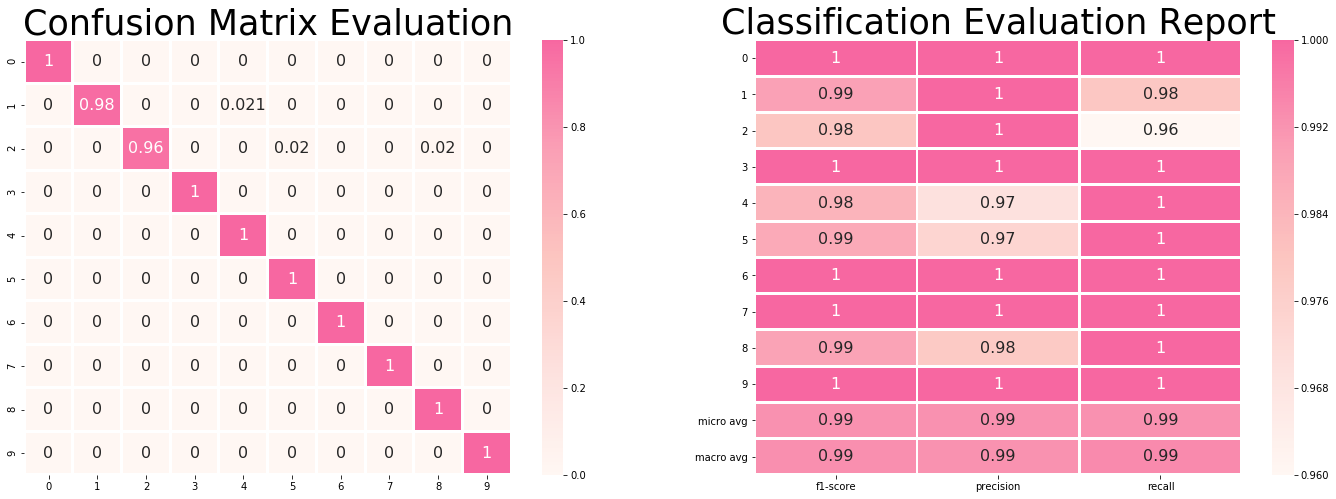

<Figure size 432x288 with 0 Axes>

In [87]:
cm = confusion_matrix(yLabels, predLabels)
cmNorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmNorm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])

target_names = list("0123456789")
labels = np.arange(10)
clf_report = classification_report(yLabels,
                                   predLabels,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)


plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
sns.heatmap(df_cm, annot=True, cmap="RdPu", 
                center=True, linewidths=2,annot_kws={'size':16})
plt.title('Confusion Matrix Evaluation', fontsize=35)


plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:-1].T, 
            annot=True,cmap="RdPu", center=True, linewidths=2,annot_kws={'size':16})
plt.title('Classification Evaluation Report', fontsize = 35)

plt.show()
plt.savefig('./Evaluation/resnet.png')